In [1]:
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from utils import setup_plotting_standards, plotTree, plotPoints
import baltic as bt
import numpy as np

setup_plotting_standards()
COLOR = '#343434'

# Supplemental Figure 1: Maximum-likelihood tree
Here we assess amount of evolution displayed by CholGEN sequences by plotting the phylogeny from the maximum-likelihood reconstruction.

First, we load the metadata for the tree. 

In [2]:
md = list()
for file in ["supplemental_data1.csv", "supplemental_data2.csv"]:
    df = pd.read_csv( "../data/" + file, usecols=["taxa", "te", "included_analysis"] )
    df["workshop"] = (file == "supplemental_data1.csv")
    md.append( df )
    
md = pd.concat( md )
md = md.drop_duplicates()
md = md.loc[md["taxa"]!="Africa|KEN|KEN-2007-002|T13|2007-01-01"]
md = md.set_index( "taxa" )
workshop_dict = md["workshop"].to_dict()
te_dict = md["te"].to_dict()
md.head()

,te,included_analysis,workshop
taxa,,,
Africa|COD|DC-0106109|T10|2022-10-25,T10,True,True
Africa|COD|DC-188126|T10|2023-01-05,T10,True,True
Africa|COD|DC-295115|T10|2023-01-06,T10,True,True
Africa|COD|DC-101125|T10|2022-01-01,T10,True,True
Africa|COD|DC-0067116|T10|2023-01-02,T10,True,True


Next, we load the tree. 

In [3]:
tree = bt.loadNewick( "../data/2025.04.23_ML_GTR.tree" )
tree.treeStats()


Tree height: 0.024485
Tree length: 1.231702

Numbers of objects in tree: 6202 (3100 nodes and 3102 leaves)



Next, we extract the subtree corresponding to the third wave of 7PET.

In [4]:
origins = [
    "Asia|IND|ERR1880804|UNK|1993-01-01",
    "Asia|IND|ERR018127|UNK|1989-01-01",
    "Asia|NPL|ERR1879576|UNK|1994-01-01",
    "Asia|IND|ERR018126|UNK|1990-01-01",
    "Asia|IND|ERR1880844|UNK|1992-01-01",
    "Asia|BGD|ERR018122|UNK|1991-01-01",
    "Asia|BGD|ERR025396|UNK|1991-01-01",
    "Asia|IND|ERR1880805|UNK|1993-01-01",
    "Asia|IND|ERR1880842|UNK|1989-01-01",
]

origin_nodes = [node for node in tree.getExternal() if node.name in origins]
mrca = tree.commonAncestor( origin_nodes )
wave3 = tree.subtree( starting_node=mrca )
root_height = mrca.parent.height
#wave3.root.parent.x -= root_height
for node in wave3.Objects:
    node.x -= root_height

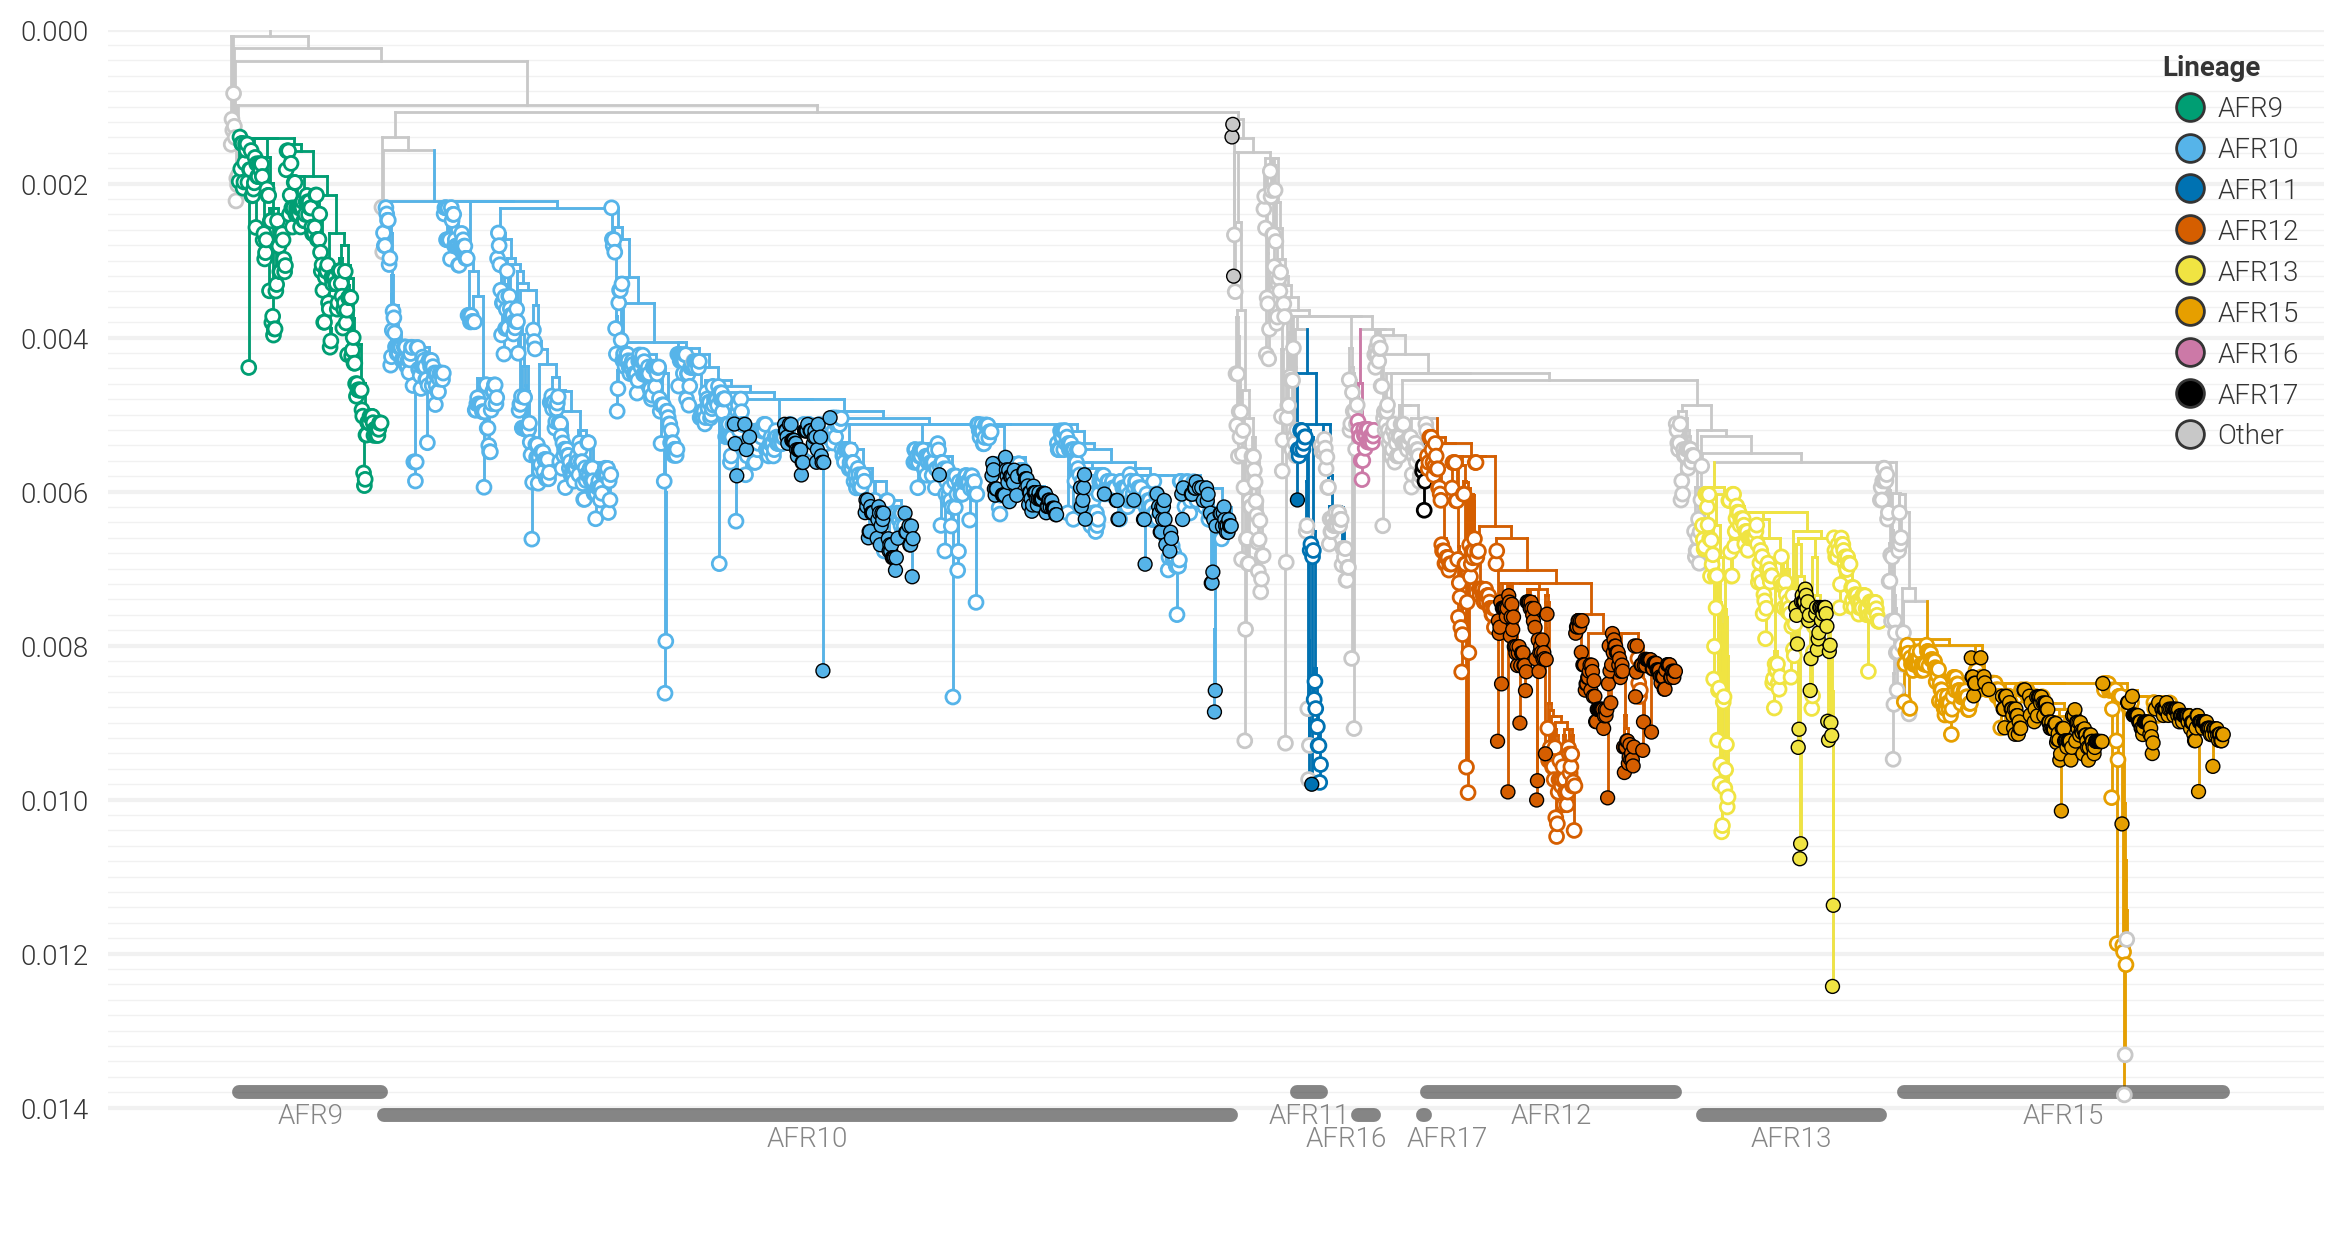

In [5]:
color_map = {
    "T9" : "#009E73", # green
    "T10" : "#56B4E9", # blue
    "T11" : "#0072B2",  # reddish-purple
    "T12" : "#D55E00", # brown 
    "T13" : "#F0E442", # yellow
    "T15" : "#E69F00", # orange 
    "T16" : "#CC79A7",
    "T17" : "#000000",
    "Other" : "#C8C8C8" # grey
}

def color_func( label ):
    lineage = te_dict.get( label, "Other" )
    #if lineage == "Other":
    #    lineage = label.split( "|" )[3]
    return color_map.get( lineage, color_map["Other"] )
    
def is_workshop( node, inverse=False ):
    if not node.is_leaf():
        return False
    return inverse ^ workshop_dict.get( node.name, False )


fig, ax = plt.subplots( dpi=200, figsize=(12,6.5) )
x_attr = lambda k: k.x
node_func = lambda k: color_func( k.name )
c_func = lambda k: color_map["Other"]
plotTree( wave3, ax, x_attr=x_attr, colour=color_map["Other"], linewidth=1, horizontal=True )
plotPoints( wave3, ax, x_attr=x_attr, target=lambda x: is_workshop(x, inverse=True), size=25, colour="w", outline_colour=node_func, outline_size=40, zorder=100, horizontal=True, style="nate", linewidth=1 )
plotPoints( wave3, ax, x_attr=x_attr, target=is_workshop, size=25, colour=node_func, zorder=150, horizontal=True, style="nate", linewidth=0.5 )

ax.set_xticks([])
ax.set_xticklabels([])
ax.tick_params( axis="y", left=False, right=False, which="both", labelbottom=True, labelsize=10 )
#ax.set_xlim(-20,tree.ySpan+10)

ax.set_yticks( np.arange( 0, 0.016, 0.002 ), minor=False )
ax.set_yticks( np.arange( 0, 0.0142, 0.0002 ), minor=True )
ax.set_ylim( 0, 0.0155 )

ax.grid( which="major", axis="y", linewidth=1.5, color="#F1F1F1", zorder=1 )
ax.grid( which="minor", axis="y", linewidth=0.5, color="#F1F1F1", zorder=1 )

[ax.spines[loc].set_visible(False) for loc in ax.spines]

count = 0
for lin in ["T9", "T10", "T11", "T16", "T12", "T13", "T15", "T17"]:
    representatives = md.loc[md["te"]==lin].index.to_list()

    rep_nodes = [node for node in wave3.getExternal() if node.name in representatives]
    mrca = wave3.commonAncestor( rep_nodes )
    subtree = wave3.subtree( starting_node=mrca )
    plotTree( subtree, ax, x_attr=x_attr, colour=color_map[lin], linewidth=1, horizontal=True )
    
    span = [tip.y for tip in wave3.getExternal() if tip.name in representatives]
    min_span = min( span )
    max_span = max( span )
    yloc = 0.0138 + 0.0003 * (count % 2)
    ax.hlines( yloc, min_span, max_span, colors=COLOR, alpha=0.6, linewidth=5, capstyle="round", label=lin )
    
    if lin == "T16":
        max_span -= 60
    elif lin == "T17":
        max_span += 50
    ax.text( (min_span + max_span) / 2, yloc+0.0003, lin.replace( "T", "AFR" ), ha="center", va="center", fontsize=10, alpha=0.6 )
    
    count += 1

legend2 = [
    Line2D([0], [0], linestyle='none', marker='o', color=color_map[country], markeredgecolor=COLOR, markeredgewidth=1, label=country.replace( "T", "AFR" ), markersize=10 ) for country in ["T9", "T10", "T11", "T12", "T13", "T15", "T16", "T17", "Other"] 
]

legend2 = ax.legend( title="Lineage", handles=legend2, loc="upper right", handletextpad=0.0, frameon=False, fontsize=10, alignment="left", title_fontproperties={ "size" : 10, "weight" : "bold" } )

ax.invert_yaxis()
ax.invert_xaxis()

plt.tight_layout()
fig.savefig( "plots/figureS1-ML-tree.pdf" )
fig.savefig( "plots/figureS1-ML-tree.png" )
plt.show()